In [1]:
%load_ext autoreload
%autoreload 2

# Imports and Setup

In [2]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import math
import time
import scipy
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import gaussian_kde
# import seaborn as sns # v 0.11.0
import os
import h5py
import numpy as np
from astropy import units as u, constants as const

In [3]:
###### # Setup Plotting Defaults #
###################################### ##
# For more options see https://matplotlib.org/users/customizing.html

from cycler import cycler

import os
os.environ["PATH"] += os.pathsep + '/global/software/sl-7.x86_64/modules/tools/texlive/2016/bin/x86_64-linux/'

# Commands for high detail plots (much larger in file size though)
#mpl.rcParams['agg.path.chunksize'] = 1000
#mpl.rcParams['savefig.epi'] = 1000

# Line styles
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['lines.antialiased'] = True
mpl.rcParams['lines.dashed_pattern'] = 2.8, 1.5
mpl.rcParams['lines.dashdot_pattern'] = 4.8, 1.5, 0.8, 1.5
mpl.rcParams['lines.dotted_pattern'] = 1.1, 1.1
mpl.rcParams['lines.scale_dashes'] = True

# Default colors
from cycler import cycler
mpl.rcParams['axes.prop_cycle'] = cycler('color',['cornflowerblue','forestgreen','maroon','goldenrod','firebrick','mediumorchid'])


# Fonts
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'CMU Serif'
mpl.rcParams['font.sans-serif'] = 'CMU Sans Serif, DejaVu Sans, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif'

# Axes
mpl.rcParams['axes.linewidth'] = 1.0
mpl.rcParams['axes.labelsize'] = 25
mpl.rcParams['axes.labelpad'] = 9.0
                                                  
                                                  
# Tick marks - the essence of life
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 2.5
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.labelsize'] = 22
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2.5
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.major.pad'] = 8
mpl.rcParams['ytick.labelsize'] = 22
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.minor.visible'] = True

# Legend
mpl.rcParams['legend.fontsize'] = 18
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1.
#mpl.rcParams['legend.edgecolor'] = 'black'
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderpad'] = 0.4 # border whitespace
mpl.rcParams['legend.labelspacing'] = 0.5 # the vertical space between the legend entries
mpl.rcParams['legend.handlelength'] = 1.5 # the length of the legend lines
mpl.rcParams['legend.handleheight'] = 0.7 # the height of the legend handle
mpl.rcParams['legend.handletextpad'] = 0.5 # the space between the legend line and legend text
mpl.rcParams['legend.borderaxespad'] = 0.5 # the border between the axes and legend edge
mpl.rcParams['legend.columnspacing'] = 2.0 # column separation


# Figure size
mpl.rcParams['figure.figsize'] = 16, 8

# Save details
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['savefig.pad_inches'] = 0.1

mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20

mpl.rcParams['text.usetex'] = True

# Load Data

In [6]:
import h5py
import numpy as np # often useful to work with the data as numpy arrays

filename = '../../XMM_BSO_DATA/data/XMM-BSO-dataset-MOS.hdf5'

with h5py.File(filename, 'r') as f:
    # f is a File object, acting like a dictionary/group
    # You can list the top-level keys (group/dataset names)
    print("Keys in the file:", list(f.keys()))

    ring_1_cts = np.array(f['ring_1']['cts'][()])
    ring_1_exp = np.array(f['ring_1']['wht'][()])
    sig_flux =  ring_1_cts / ring_1_exp
    sig_err =  np.sqrt(ring_1_cts) / ring_1_exp
    bkg_flux = np.zeros_like(sig_flux)
    bkg_cts = np.zeros_like(sig_flux)
    bkg_exp = []
    count = 0
    for i in range(20, 31):
        ring_cts = np.array(f[f'ring_{i}']['cts'][()])
        ring_exp = np.array(f[f'ring_{i}']['wht'][()])
        bkg_flux += ring_cts / ring_exp
        bkg_cts += ring_cts
        bkg_exp.append(ring_exp)
        count += 1
    bkg_flux /= count
    bkg_err = np.sqrt(bkg_cts) / np.sum(bkg_exp)
    emin = f['emin_o'][()]
    emax = f['emax_o'][()]
    bkg_sub = sig_flux - bkg_flux
    bkg_sub_err = np.sqrt(sig_err**2 + bkg_err**2)


Keys in the file: ['emax_i', 'emax_o', 'emin_i', 'emin_o', 'ring_1', 'ring_10', 'ring_11', 'ring_12', 'ring_13', 'ring_14', 'ring_15', 'ring_16', 'ring_17', 'ring_18', 'ring_19', 'ring_2', 'ring_20', 'ring_21', 'ring_22', 'ring_23', 'ring_24', 'ring_25', 'ring_26', 'ring_27', 'ring_28', 'ring_29', 'ring_3', 'ring_30', 'ring_4', 'ring_5', 'ring_6', 'ring_7', 'ring_8', 'ring_9']


In [18]:
db_factor = 6

def downbin(arr, factor=4):
    """Downbin array by averaging groups of `factor` elements."""
    n = len(arr) // factor * factor  # trim to multiple of factor
    return arr[:n].reshape(-1, factor).sum(axis=1)

bkg_flux_db = downbin(bkg_flux, db_factor)
sig_flux_db = downbin(sig_flux, db_factor)
bkg_sub_db = downbin(bkg_sub, db_factor)

def downbin_errors(arr, factor=4):
    """Downbin errors by adding in quadrature and averaging."""
    n = len(arr) // factor * factor  # trim to multiple of factor
    return np.sqrt((arr[:n].reshape(-1, factor)**2).sum(axis=1))

bkg_err_db = downbin_errors(bkg_err, db_factor)
sig_err_db = downbin_errors(sig_err, db_factor)
bkg_sub_err_db = downbin_errors(bkg_sub_err, db_factor)

def downbin_boundaries(emin, emax, factor=4):
    """Downbin energy bin boundaries by factor."""
    n = len(emin) // factor * factor  # trim to multiple of factor
    emin_db = emin[:n:factor]  # take every factor-th element starting from 0
    emax_db = emax[factor-1:n:factor]  # take every factor-th element starting from factor-1
    return emin_db, emax_db

emin_db, emax_db = downbin_boundaries(emin, emax, db_factor)

E_centers_db = (emin_db + emax_db) / 2
E_diff_db = emax_db - emin_db

In [67]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# Mask for the 3-8 keV region
mask = (E_centers_db >= 3) & (E_centers_db <= 8)
X_train = E_centers_db[mask].reshape(-1, 1)
y_train = y_data[mask]
y_err_train = y_err[mask]

# Increased upper bound on length_scale
kernel = RBF(length_scale=0.3, length_scale_bounds=(0.29, 0.31))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10, normalize_y=True)
gp.fit(X_train, y_train)

print(f"Optimized length_scale: {gp.kernel_.length_scale:.3f}")

# Predict on a fine grid within 3-8 keV
X_pred = np.linspace(3, 8, 500).reshape(-1, 1)
y_pred, y_std = gp.predict(X_pred, return_std=True)
# print(y_std)

Optimized length_scale: 0.310


/global/homes/k/kraman18/.conda/envs/dm_decay_mega/lib/python3.14/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 0.31. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


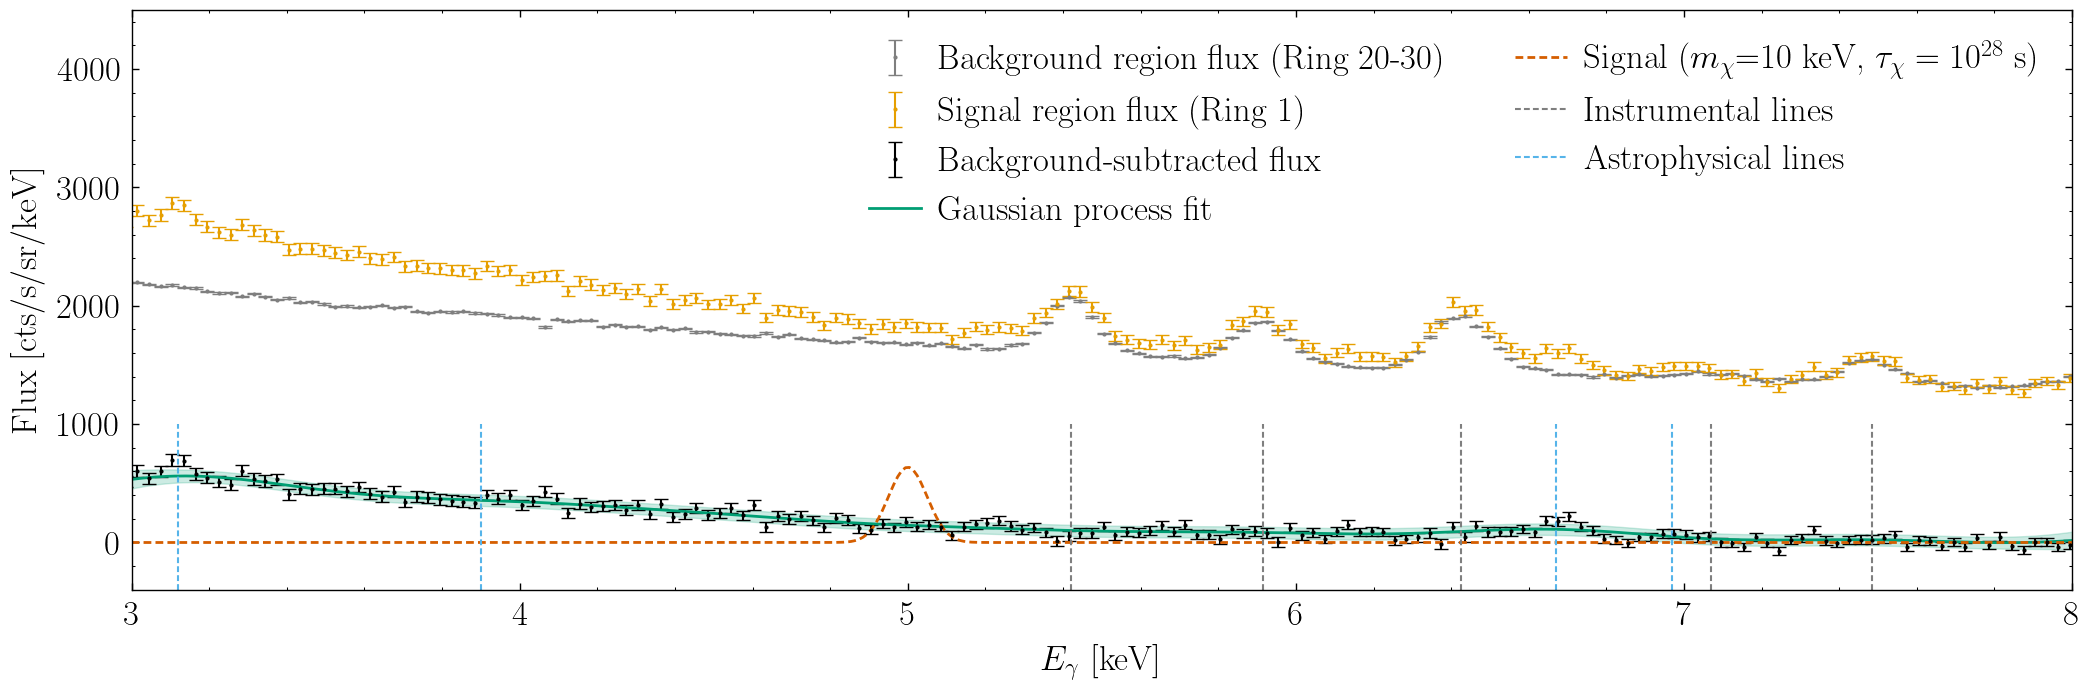

In [138]:
colors = [
    "#000000",  # black
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
]

fig, axs = plt.subplots(figsize=(21,7))

axs.errorbar(E_centers_db, bkg_flux_db / E_diff_db, yerr=bkg_err_db / E_diff_db, 
             c='tab:grey', label='Background region flux (Ring 20-30)', fmt='o', markersize=2, capsize=5)
axs.errorbar(E_centers_db, sig_flux_db / E_diff_db, yerr=sig_err_db / E_diff_db, 
             c=colors[1], label='Signal region flux (Ring 1)', fmt='o', markersize=2, capsize=5)
axs.errorbar(E_centers_db, bkg_sub_db / E_diff_db, yerr=bkg_sub_err_db / E_diff_db, 
             c=colors[0], label='Background-subtracted flux', fmt='o', markersize=2, capsize=5)

# Plot GP mean and uncertainty band
axs.plot(X_pred, y_pred, c=colors[3], linewidth=2, label='Gaussian process fit')
axs.fill_between(X_pred.ravel(), y_pred - y_std, y_pred + y_std, 
                  alpha=0.2, color=colors[3])

D_factor = 8e28 # keV/cm^2
tau = 1e28
mchi = 10.
Aeff = 300
flux = 1. / (4 * np.pi * mchi * tau) * D_factor * Aeff / E_diff_db[0]

# Line feature at mchi/2 smeared by detector resolution
E_line = mchi/2  # keV
sigma = 0.05  # keV (detector resolution)

amplitude = 500  # adjust to scale the line height
E_fine = np.linspace(3, 8, 500)
line_profile = flux * np.exp(-0.5 * ((E_fine - E_line) / sigma)**2)

axs.plot(E_fine, line_profile, c=colors[6], linewidth=2, linestyle='--', label=rf'Signal ($m_{{\chi}}$={int(E_line*2)} keV, $\tau_{{\chi}}=10^{{{int(np.log10(tau))}}}$ s)')

inst_line_list = [5.42, 5.915, 6.425, 7.07, 7.485, 8.06]
for i, line in enumerate(inst_line_list):
    axs.vlines(line, ymin=-400, ymax=1000, ls='--', color='tab:grey', 
               label='Instrumental lines' if i == 0 else None)

astro_line_list = [2.46, 2.62, 3.12, 3.90, 6.67, 6.97]
for i, line in enumerate(astro_line_list):
    axs.vlines(line, ymin=-400, ymax=1000, ls='--', color=colors[2], 
               label='Astrophysical lines' if i == 0 else None)

axs.set_xlim(3, 8)
axs.set_ylim(-400, 4500)

axs.tick_params(axis='x', labelsize=25)
axs.tick_params(axis='y', labelsize=25)

# Option 1: Manually reorder legend handles
handles, labels = axs.get_legend_handles_labels()
# Reorder as needed, e.g., put first 3 items (errorbars) before the rest
order = [4, 5, 6, 0, 1, 2, 3]  # adjust indices as needed
axs.legend([handles[i] for i in order], [labels[i] for i in order], loc='upper right', frameon=False, fontsize=25, ncol=2)


axs.set_xlabel(r'$E_{\gamma}$ [keV]', fontsize=25)
axs.set_ylabel(r'Flux [cts/s/sr/keV]', fontsize=25)

plt.tight_layout()
# plt.show()
plt.savefig('../plots/analysis_example.pdf')

